# Spotify Data Inference

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from persistence import db_create_conn, DBPlay, DBSpotipySong, DBSpotipyAlbum, DBSpotipyArtist, Config, load_model_json
from classify_genres import classify_genres
from logging import Logger
from classify_genres import LLMConnector

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
cfg = load_model_json(Config, "config.json")
db = db_create_conn(cfg.db_fp)

### Monthly data collation

To make things a little more simple to interpret, we will collate the data into monthly summaries.

In [4]:
all_plays = DBPlay.get_all(db)
all_songs = {song.track_id: song for song in DBSpotipySong.get_all(db)}
all_albums = {album.album_id for album in DBSpotipyAlbum.get_all(db)}
all_artists = {artist.artist_id: artist for artist in DBSpotipyArtist.get_all(db)}

In [5]:
def collate_monthly(p: list[DBPlay]) -> dict[dt.date, list[DBPlay]]:
    monthly_plays = {}
    for play in p:
        played_at = dt.datetime.fromisoformat(play.ts)
        month = dt.date(played_at.year, played_at.month, 1)
        monthly_plays[month] = monthly_plays.get(month, [])
        monthly_plays[month].append(play)
    return monthly_plays


monthly_plays = collate_monthly(all_plays)

### Get all genres

In [6]:
def get_all_genres(p: dict[dt.date, list[DBPlay]]) -> list[str]:
    genres = {}
    for month, plays in p.items():
        for play in plays:
            song = all_songs.get(play.track_id, None)
            if song is None:
                continue
            artists = [all_artists[artist_id] for artist_id in song.artist_ids_csv.split(",")]
            song_genres = [genre for artist in artists for genre in artist.genres_csv.split(",")]
            for genre in song_genres:
                genres[genre] = genres.get(genre, 0) + 1
    genres = sorted(genres.items(), key=lambda x: x[1], reverse=True)
    genres = {g: c for g, c in genres}
    return genres

genres = get_all_genres(monthly_plays)
print(f"Total genres you listened to: {len(genres)}")
top_k = 50
for i, (g, c) in enumerate(genres.items()):
    if i >= top_k:
        break
    print(f"{i+1}. {g}: {c}")

Total genres you listened to: 2145
1. : 62589
2. soft rock: 38012
3. pop: 32549
4. liquid funk: 29783
5. rock: 28472
6. mellow gold: 27251
7. classic rock: 20093
8. drum and bass: 18252
9. yacht rock: 17748
10. album rock: 17346
11. uk dnb: 17157
12. dance pop: 15984
13. rap: 15604
14. indie soul: 13783
15. edm: 12198
16. hip hop: 11943
17. disco: 11746
18. new wave pop: 11425
19. soul: 11063
20. dancefloor dnb: 10716
21. permanent wave: 9976
22. singer-songwriter: 9962
23. uk dance: 9873
24. quiet storm: 9654
25. pop dance: 9329
26. modern rock: 9148
27. vapor twitch: 8771
28. new romantic: 8201
29. funk: 7408
30. pop rap: 6851
31. folk rock: 6769
32. alternative rock: 6588
33. hard rock: 6571
34. new wave: 6501
35. electro house: 6254
36. vapor soul: 6247
37. deep dnb: 5873
38. uk pop: 5763
39. adult standards: 5723
40. motown: 5524
41. house: 5394
42. bass house: 5335
43. alternative r&b: 5277
44. sophisti-pop: 5187
45. indietronica: 4714
46. neurofunk: 4544
47. classic soul: 4441
4

In [7]:
with open(cfg.classified_genres_fp, 'r') as f:
    classified_genres = json.load(f)


def fetch_missing_genres(genres: list[str], classified_genres: dict[str, str]) -> dict[str, str]:
    missing = set(genres) - set(classified_genres.keys())
    if len(missing) == 0:
        return classified_genres
    llm = LLMConnector(Logger("llm"), cfg.ollama_host, cfg.ollama_model)
    classified_missing = classify_genres(list(missing), cfg.fundamental_genres, llm)
    classified_genres.update(classified_missing)
    return classified_genres

classified_genres = fetch_missing_genres(list(genres.keys()), classified_genres)

with open(cfg.classified_genres_fp, 'w') as f:
    json.dump(classified_genres, f, indent=2)

### Genre distribution over time

In [8]:
def collate_genres_monthly(p: dict[dt.date, list[DBPlay]]):
    genres = {}  # month -> genre -> count
    for month, plays in p.items():
        genres[month] = {}
        for play in plays:
            song = all_songs.get(play.track_id, None)
            if song is None:
                continue
            artists = [all_artists[artist_id] for artist_id in song.artist_ids_csv.split(",")]
            song_genres = [genre for artist in artists for genre in artist.genres_csv.split(",")]
            for genre in song_genres:
                genres[month][genre] = genres[month].get(genre, 0) + 1

    # get all genres
    all_genres = set()
    for month, genre_counts in genres.items():
        all_genres.update(genre_counts.keys())

    # get all months
    all_months = set(genres.keys())
    all_months = sorted(all_months)

    # map: genre -> month -> count
    genre_monthly = {
        genre: {
            month: genre_counts.get(genre, 0)
            for month, genre_counts in genres.items()
        } for genre in all_genres
    }
    
    return all_months, genre_monthly


all_months, genres_monthly = collate_genres_monthly(monthly_plays)

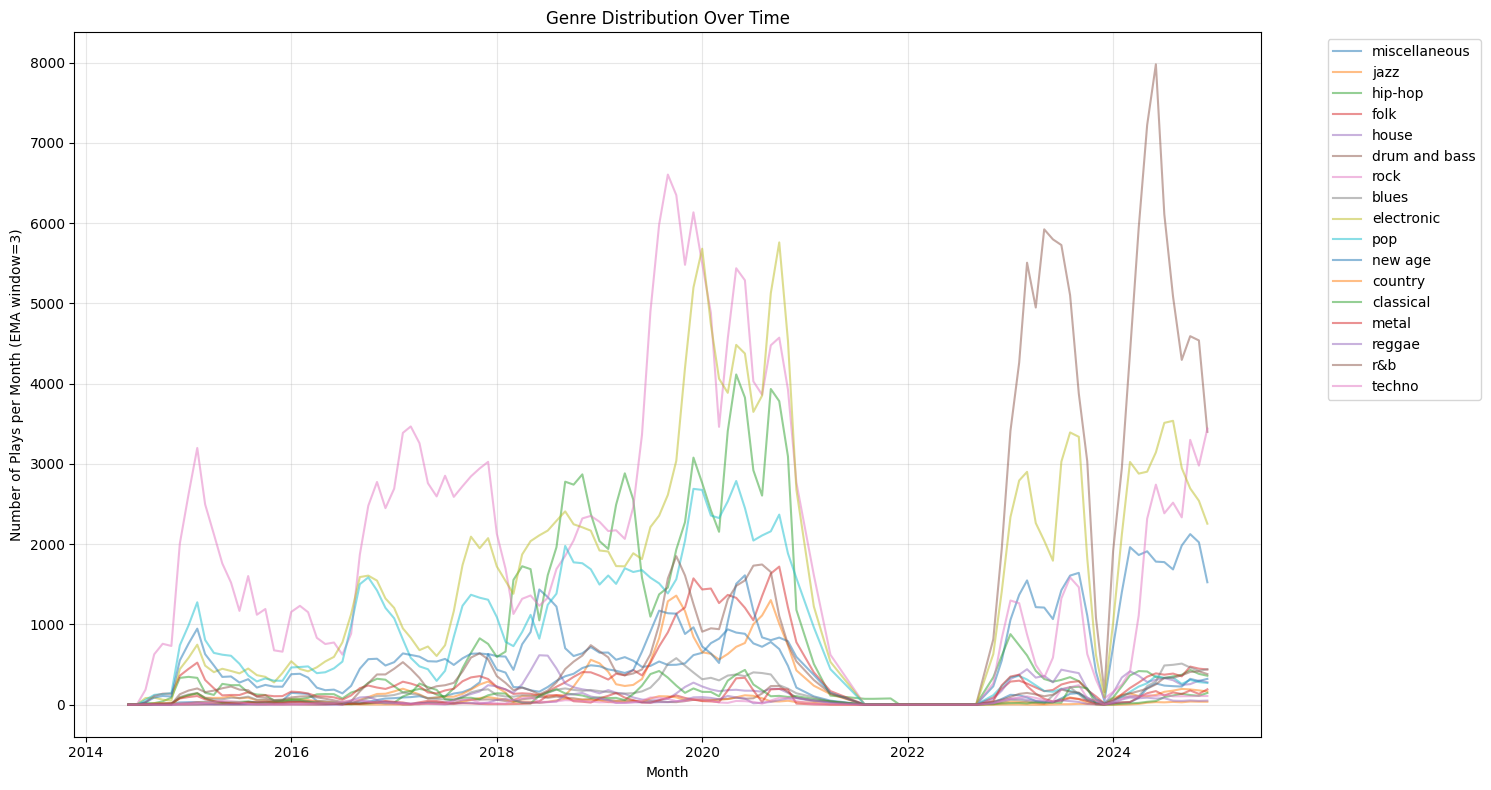

In [9]:
def ema(xs: list[int], window: int) -> list[int]:
    ema = [0] * len(xs)
    for i in range(len(xs)):
        ema[i] = sum(xs[i-window+1:i+1]) / window
    return ema

def plt_classified_genres_monthly(
    all_months: set[dt.date],
    genres_monthly: dict[str, dict[dt.date, int]],
    classified_genres: dict[str, str]
):
    classified_genres_monthly = {}
    for genre, month_counts in genres_monthly.items():
        classified = classified_genres[genre]
        if classified not in classified_genres_monthly:
            classified_genres_monthly[classified] = {m: 0 for m in all_months}
        for month, count in month_counts.items():
            classified_genres_monthly[classified][month] += count

    plt.figure(figsize=(15, 8))
    
    for genre, month_counts in classified_genres_monthly.items():
        months = list(month_counts.keys())
        counts = list(month_counts.values())
        counts = ema(counts, 3)
        plt.plot(months, counts, label=genre, alpha=0.5)
    
    plt.xlabel('Month')
    plt.ylabel('Number of Plays per Month (EMA window=3)') 
    plt.title('Genre Distribution Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plt_classified_genres_monthly(all_months, genres_monthly, classified_genres)